#Transfer Learning with TensorFlow Hub for TFLite

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.2.0
• Using TensorFlow Hub Version:  0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


#Select the Hub/TF2 Module to Use
Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [2]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280



#Data Preprocessing
Use TensorFlow Datasets to load the cats and dogs dataset.

This tfds package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see loading image data

The tfds.load method downloads and caches the data, and returns a tf.data.Dataset object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since "cats_vs_dog" doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = ['train[:80%]', 'train[80%:90%]', 'train[90%:100%]'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

#Format the Data
Use the tf.image module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [0]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

In [0]:
BATCH_SIZE = 32

In [0]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [8]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

#Defining the Model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [0]:
do_fine_tuning = False

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [10]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
NUM_LAYERS = 8 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

#Training the Model

In [0]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [13]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 29s 49ms/step - loss: 0.0619 - accuracy: 0.9780 - val_loss: 0.0363 - val_accuracy: 0.9875
Epoch 2/5
582/582 [==============================] - 28s 48ms/step - loss: 0.0310 - accuracy: 0.9898 - val_loss: 0.0357 - val_accuracy: 0.9897
Epoch 3/5
582/582 [==============================] - 28s 47ms/step - loss: 0.0254 - accuracy: 0.9910 - val_loss: 0.0373 - val_accuracy: 0.9897
Epoch 4/5
582/582 [==============================] - 28s 48ms/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 0.0398 - val_accuracy: 0.9875
Epoch 5/5
582/582 [==============================] - 28s 48ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0424 - val_accuracy: 0.9862


In [0]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

In [15]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [16]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [0]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [18]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


#Convert Using TFLite's Converter
Load the TFLiteConverter with the SavedModel

In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

##Post-Training Quantization¶
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [0]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]


#Post-Training Integer Quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [0]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [0]:
converter.representative_dataset = representative_data_gen

#Full Integer Quantization
To require the converter to only output integer operations, one can specify:

In [0]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

#Finally convert the model

In [0]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

#Test the TFLite Model Using the Python Interpreter

In [0]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [26]:

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

10it [00:08,  1.22it/s]


In [0]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

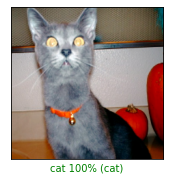

In [29]:

#@title Visualize the outputs { run: "auto" }
index = 4 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [0]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

In [0]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass